# C GAN

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [3]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 200000
batch_size = 128
display_step = 500

# Network parameters.
noise_dim = 100 # Noise data points.

In [4]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [5]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [6]:
# Create TF Model.
class Generator(Model):
    # Set layers.
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = layers.Dense(7 * 7 * 128)
        self.bn1 = layers.BatchNormalization()
        self.conv2tr1 = layers.Conv2DTranspose(64, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.conv2tr2 = layers.Conv2DTranspose(1, 5, strides=2, padding='SAME')

    # Set forward pass.
    def call(self, x, label, is_training=False):
        x = tf.concat([x, label],axis=1)
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = self.conv2tr1(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = self.conv2tr2(x)
        x = tf.nn.tanh(x)
        return x

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
class Discriminator(Model):
    # Set layers.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='SAME')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(128, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024)
        self.bn3 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2)

    # Set forward pass.
    def call(self, x, label, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.flatten(x)
        x = tf.concat([x, label],axis=1)
        x = self.fc1(x)
        x = self.bn3(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        return self.fc2(x)

# Build neural network model.
generator = Generator()
discriminator = Discriminator()

In [7]:
# Losses.
def generator_loss(reconstructed_image):
    gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=reconstructed_image, labels=tf.ones([batch_size], dtype=tf.int32)))
    return gen_loss

def discriminator_loss(disc_fake, disc_real):
    disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
    return disc_loss_real + disc_loss_fake

# Optimizers.
optimizer_gen = tf.optimizers.Adam(learning_rate=lr_generator)
optimizer_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)

In [10]:
# Optimization process. Inputs: real image and noise.
def run_optimization(real_images, labels):
    
    # Rescale to [-1, 1], the input range of the discriminator
    real_images = real_images * 2. - 1.

    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, labels, is_training=True)
        disc_fake = discriminator(fake_images, labels, is_training=True)
        disc_real = discriminator(real_images, labels, is_training=True)

        disc_loss = discriminator_loss(disc_fake, disc_real)
            
    # Training Variables for each optimizer
    gradients_disc = g.gradient(disc_loss,  discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients_disc,  discriminator.trainable_variables))
    
    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, labels, is_training=True)
        disc_fake = discriminator(fake_images, labels, is_training=True)

        gen_loss = generator_loss(disc_fake)
            
    gradients_gen = g.gradient(gen_loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [11]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps + 1)):
    batch_y = to_categorical(batch_y)
    batch_y = tf.cast(batch_y, tf.float32)
    
    if step == 0:
        # Generate noise.
        noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
        gen_loss = generator_loss(discriminator(generator(noise, batch_y), batch_y))
        disc_loss = discriminator_loss(discriminator(batch_x, batch_y), discriminator(generator(noise, batch_y), batch_y))
        print("initial: gen_loss: %f, disc_loss: %f" % (gen_loss, disc_loss))
        continue
    
    # Run the optimization.
    gen_loss, disc_loss = run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        print("step: %i, gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))

initial: gen_loss: 0.687370, disc_loss: 1.442660
step: 500, gen_loss: 2.375842, disc_loss: 0.290571
step: 1000, gen_loss: 2.128632, disc_loss: 0.440344
step: 1500, gen_loss: 2.849523, disc_loss: 0.358814
step: 2000, gen_loss: 2.634591, disc_loss: 0.268755
step: 2500, gen_loss: 3.196488, disc_loss: 0.245166
step: 3000, gen_loss: 3.741001, disc_loss: 0.171512
step: 3500, gen_loss: 3.587307, disc_loss: 0.142541
step: 4000, gen_loss: 3.607323, disc_loss: 0.124568
step: 4500, gen_loss: 4.302686, disc_loss: 0.204791
step: 5000, gen_loss: 3.025012, disc_loss: 0.273140
step: 5500, gen_loss: 3.206779, disc_loss: 0.251626
step: 6000, gen_loss: 2.930162, disc_loss: 0.356553
step: 6500, gen_loss: 2.653489, disc_loss: 0.505986
step: 7000, gen_loss: 2.525524, disc_loss: 0.629481
step: 7500, gen_loss: 2.169511, disc_loss: 0.514819
step: 8000, gen_loss: 2.370711, disc_loss: 0.570225
step: 8500, gen_loss: 3.063212, disc_loss: 0.341553
step: 9000, gen_loss: 2.587950, disc_loss: 0.498329
step: 9500, gen_

step: 78000, gen_loss: 8.843852, disc_loss: 0.019679
step: 78500, gen_loss: 6.739763, disc_loss: 0.083419
step: 79000, gen_loss: 7.799727, disc_loss: 0.068565
step: 79500, gen_loss: 4.488023, disc_loss: 0.111474
step: 80000, gen_loss: 6.476758, disc_loss: 0.059482
step: 80500, gen_loss: 7.171435, disc_loss: 0.028724
step: 81000, gen_loss: 7.500202, disc_loss: 0.041686
step: 81500, gen_loss: 6.546262, disc_loss: 0.079863
step: 82000, gen_loss: 8.004476, disc_loss: 0.095318
step: 82500, gen_loss: 6.678963, disc_loss: 0.056194
step: 83000, gen_loss: 6.478731, disc_loss: 0.134609
step: 83500, gen_loss: 9.401062, disc_loss: 0.625799
step: 84000, gen_loss: 7.510420, disc_loss: 0.011738
step: 84500, gen_loss: 7.227165, disc_loss: 0.020759
step: 85000, gen_loss: 8.217575, disc_loss: 0.119706
step: 85500, gen_loss: 8.694629, disc_loss: 0.014443
step: 86000, gen_loss: 7.416728, disc_loss: 0.090740
step: 86500, gen_loss: 8.657449, disc_loss: 0.019847
step: 87000, gen_loss: 6.964628, disc_loss: 0.

step: 154500, gen_loss: 7.672040, disc_loss: 0.019351
step: 155000, gen_loss: 11.590611, disc_loss: 0.038642
step: 155500, gen_loss: 10.434713, disc_loss: 0.208951
step: 156000, gen_loss: 5.882378, disc_loss: 0.057209
step: 156500, gen_loss: 8.133858, disc_loss: 0.005268
step: 157000, gen_loss: 9.227178, disc_loss: 0.057564
step: 157500, gen_loss: 8.770419, disc_loss: 0.074017
step: 158000, gen_loss: 7.960136, disc_loss: 0.002913
step: 158500, gen_loss: 5.480932, disc_loss: 0.045572
step: 159000, gen_loss: 6.683920, disc_loss: 0.009258
step: 159500, gen_loss: 8.033403, disc_loss: 0.041182
step: 160000, gen_loss: 8.982258, disc_loss: 0.028858
step: 160500, gen_loss: 10.013349, disc_loss: 0.007153
step: 161000, gen_loss: 10.176013, disc_loss: 0.210886
step: 161500, gen_loss: 8.480699, disc_loss: 0.001047
step: 162000, gen_loss: 7.198854, disc_loss: 0.004459
step: 162500, gen_loss: 8.965384, disc_loss: 0.042665
step: 163000, gen_loss: 10.630520, disc_loss: 0.046294
step: 163500, gen_loss:

step: 230000, gen_loss: 23.786026, disc_loss: 0.000000
step: 230500, gen_loss: 23.036171, disc_loss: 0.000000
step: 231000, gen_loss: 26.636299, disc_loss: 0.000152
step: 231500, gen_loss: 27.935608, disc_loss: 0.000000
step: 232000, gen_loss: 26.479084, disc_loss: 0.000000
step: 232500, gen_loss: 25.840218, disc_loss: 0.000000
step: 233000, gen_loss: 27.626308, disc_loss: 0.009219
step: 233500, gen_loss: 22.943275, disc_loss: 0.000051
step: 234000, gen_loss: 25.230194, disc_loss: 0.000000
step: 234500, gen_loss: 24.783421, disc_loss: 0.000000
step: 235000, gen_loss: 21.804007, disc_loss: 0.000001
step: 235500, gen_loss: 26.029070, disc_loss: 0.000002
step: 236000, gen_loss: 23.966883, disc_loss: 0.000019
step: 236500, gen_loss: 22.085133, disc_loss: 0.000004
step: 237000, gen_loss: 22.047390, disc_loss: 0.000000
step: 237500, gen_loss: 27.442329, disc_loss: 0.000001
step: 238000, gen_loss: 23.290649, disc_loss: 0.001122
step: 238500, gen_loss: 26.995605, disc_loss: 0.000001
step: 2390

step: 305500, gen_loss: 12.992031, disc_loss: 0.010028
step: 306000, gen_loss: 10.612424, disc_loss: 0.027950
step: 306500, gen_loss: 9.458338, disc_loss: 0.010845
step: 307000, gen_loss: 8.706457, disc_loss: 0.049829
step: 307500, gen_loss: 7.134084, disc_loss: 0.027065
step: 308000, gen_loss: 11.486773, disc_loss: 0.004552
step: 308500, gen_loss: 8.831382, disc_loss: 0.029291
step: 309000, gen_loss: 10.727647, disc_loss: 0.010856
step: 309500, gen_loss: 12.099354, disc_loss: 0.027238
step: 310000, gen_loss: 12.805078, disc_loss: 0.033556
step: 310500, gen_loss: 10.750917, disc_loss: 0.010793
step: 311000, gen_loss: 11.813082, disc_loss: 0.088587
step: 311500, gen_loss: 10.729970, disc_loss: 0.003017
step: 312000, gen_loss: 10.899867, disc_loss: 0.011729
step: 312500, gen_loss: 8.386445, disc_loss: 0.005928
step: 313000, gen_loss: 6.356719, disc_loss: 0.027332
step: 313500, gen_loss: 11.600518, disc_loss: 0.004407
step: 314000, gen_loss: 11.756420, disc_loss: 0.002950
step: 314500, ge

step: 381000, gen_loss: 11.234486, disc_loss: 0.005125
step: 381500, gen_loss: 11.247149, disc_loss: 0.000614
step: 382000, gen_loss: 8.055119, disc_loss: 0.019110
step: 382500, gen_loss: 8.871382, disc_loss: 0.015874
step: 383000, gen_loss: 7.250963, disc_loss: 0.094335
step: 383500, gen_loss: 11.371673, disc_loss: 0.008273
step: 384000, gen_loss: 11.994719, disc_loss: 0.033718
step: 384500, gen_loss: 8.578048, disc_loss: 0.002582
step: 385000, gen_loss: 11.626816, disc_loss: 0.001185
step: 385500, gen_loss: 10.251695, disc_loss: 0.117652
step: 386000, gen_loss: 8.984728, disc_loss: 0.001986
step: 386500, gen_loss: 10.284032, disc_loss: 0.004166
step: 387000, gen_loss: 10.755326, disc_loss: 0.007447
step: 387500, gen_loss: 11.528546, disc_loss: 0.003384
step: 388000, gen_loss: 13.308454, disc_loss: 0.001072
step: 388500, gen_loss: 7.955778, disc_loss: 0.030041
step: 389000, gen_loss: 9.829324, disc_loss: 0.022464
step: 389500, gen_loss: 10.777086, disc_loss: 0.001469
step: 390000, gen

step: 456000, gen_loss: 8.961699, disc_loss: 0.006878
step: 456500, gen_loss: 13.866675, disc_loss: 0.007559
step: 457000, gen_loss: 11.232466, disc_loss: 0.081618
step: 457500, gen_loss: 6.917402, disc_loss: 0.009118
step: 458000, gen_loss: 11.246431, disc_loss: 0.002788
step: 458500, gen_loss: 12.236203, disc_loss: 0.002139
step: 459000, gen_loss: 10.519258, disc_loss: 0.006486
step: 459500, gen_loss: 8.878487, disc_loss: 0.001364
step: 460000, gen_loss: 9.807013, disc_loss: 0.028853
step: 460500, gen_loss: 8.740797, disc_loss: 0.031604
step: 461000, gen_loss: 12.172924, disc_loss: 0.000725
step: 461500, gen_loss: 9.376235, disc_loss: 0.081470
step: 462000, gen_loss: 9.548243, disc_loss: 0.007036
step: 462500, gen_loss: 12.037374, disc_loss: 0.001945
step: 463000, gen_loss: 12.989830, disc_loss: 0.024992
step: 463500, gen_loss: 7.405709, disc_loss: 0.030590
step: 464000, gen_loss: 9.445966, disc_loss: 0.015966
step: 464500, gen_loss: 9.651678, disc_loss: 0.003231
step: 465000, gen_lo

KeyboardInterrupt: 

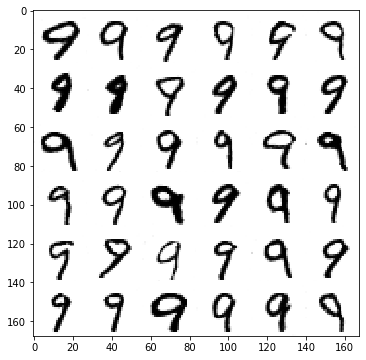

In [22]:
# Testing
# Generate images from noise, using the generator network.
write_number = 9

n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.normal(-1., 1., size=[n, noise_dim]).astype(np.float32)
    label = np.zeros([6,10])
    label[:,write_number] = 1.0
    # Generate image from noise.
    g = generator(z,label).numpy()
    # Rescale to original [0, 1]
    g = (g + 1.) / 2
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()